# Retrieve data

In [5]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Initialize Firebase
cred = credentials.Certificate("../city-sentry-firebase.json")  # Use your downloaded JSON key
firebase_admin.initialize_app(cred)

# Connect to Firestore
db = firestore.client()

# Retrieve the collection
collection_name = "reports"
docs = db.collection(collection_name).stream()

# Convert to DataFrame
data = []
for doc in docs:
    doc_dict = doc.to_dict()
    data.append(doc_dict)

df = pd.DataFrame(data)
df.drop(columns=["photo"], inplace=True)
df.to_csv("../data/reports.csv", index=False)

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

# Data Insights

In [ ]:
print(len(df))

342


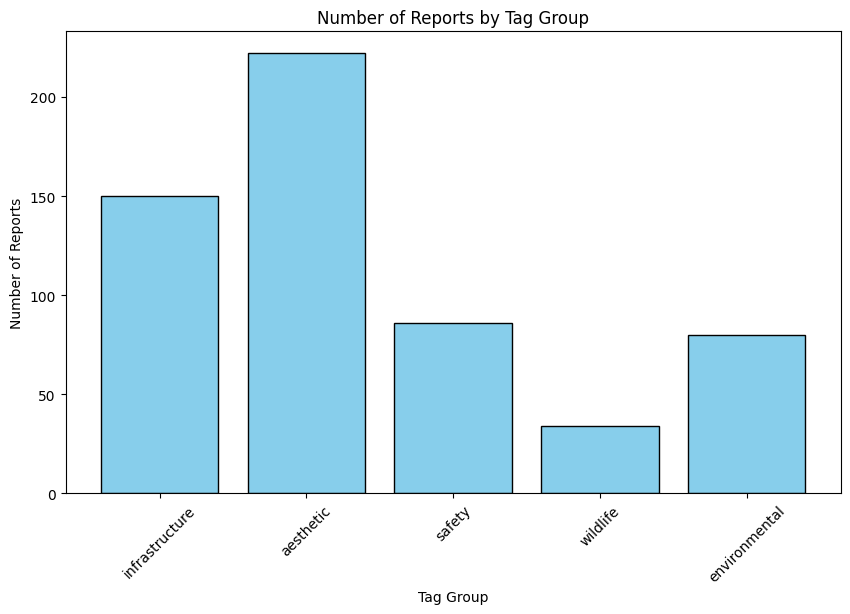

In [9]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from collections import Counter

tag_groups = {
    'environmental': ['Litter', 'Illegal Dumping', 'Air Pollution', 'Water Pollution'],
    'infrastructure': ['Pothole', 'Cracked Pavement', 'Broken Streetlight', 'Damaged Bench', 'Blocked Drainage', 'Abandoned Vehicle'],
    'safety': ['Vandalism', 'Unsafe Building', 'Unsafe Bridge', 'Broken Traffic Signals', 'Open Manholes'],
    'aesthetic': ['Overgrown Vegetation', 'Graffiti', 'Neglected Monuments', 'Faded Paint'],
    'wildlife': ['Dead Animals', 'Animal Menace']
}

# Extract tags from the 'tags' column and classify each into a group
def classify_tag(tag):
    for group, tags in tag_groups.items():
        if tag in tags:
            return group
    return 'other'

# Flatten and classify all tags from the 'tags' column
df['tag_list'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)  # Convert the string representation to an actual list
all_tags = [tag for tags in df['tag_list'] for tag in tags]  # Flatten all tags into a single list
grouped_tags = [classify_tag(tag) for tag in all_tags]  # Classify each tag into a group

# Count occurrences for each group
group_counts = Counter(grouped_tags)

# Plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(group_counts.keys(), group_counts.values(), color='skyblue', edgecolor='black')
plt.title('Number of Reports by Tag Group')
plt.xlabel('Tag Group')
plt.ylabel('Number of Reports')
plt.xticks(rotation=45)
plt.show()

# Plot data

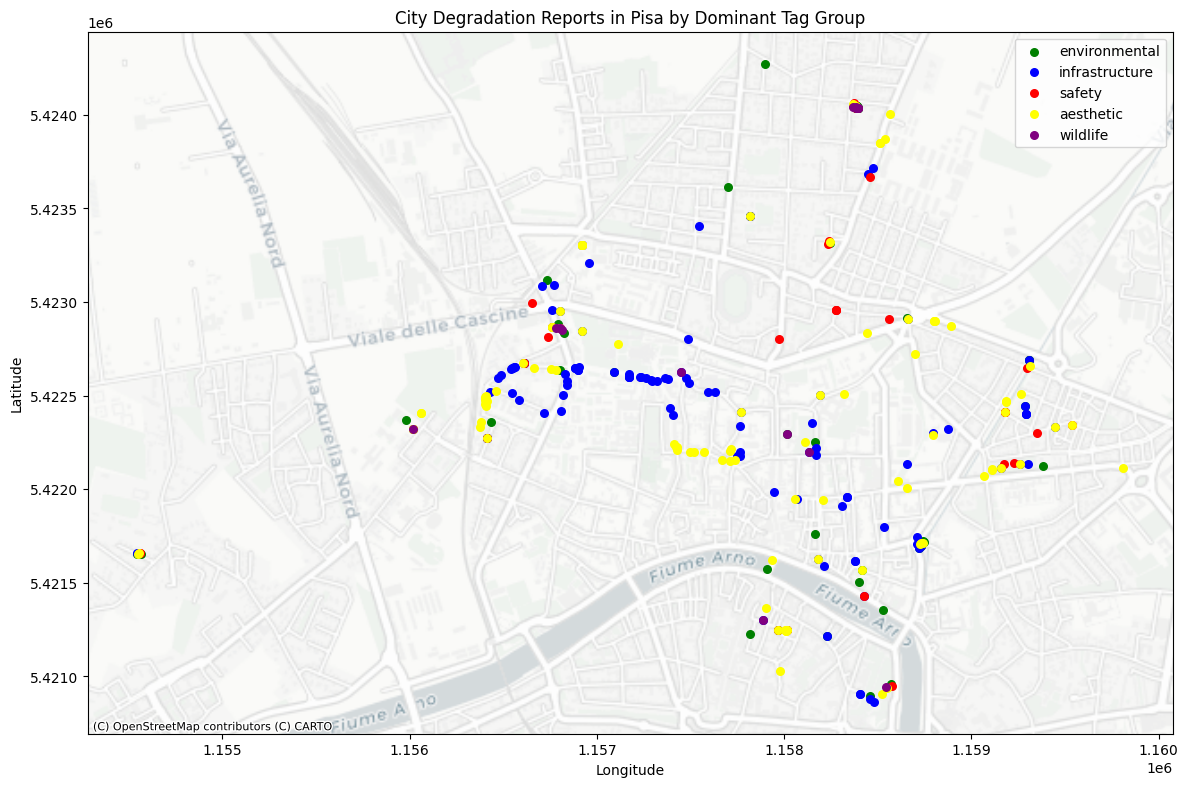

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import ast

group_colors = {
    'environmental': 'green',
    'infrastructure': 'blue',
    'safety': 'red',
    'aesthetic': 'yellow',
    'wildlife': 'purple',
}

# Ensure 'location' and 'tags' columns are properly formatted
df['location'] = df['location'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Filter only reports within Pisa's geographic boundaries
df_pisa = df.loc[
    (df['location'].apply(lambda x: x['latitude']).between(43.2, 43.8)) &
    (df['location'].apply(lambda x: x['longitude']).between(10.1, 10.9))
].copy()
df_pisa['timestamp'] = pd.to_datetime(df_pisa['timestamp'], format='ISO8601')
# Convert to GeoDataFrame
geometry = [Point(loc['longitude'], loc['latitude']) for loc in df_pisa['location']]
gdf_pisa = gpd.GeoDataFrame(df_pisa, geometry=geometry, crs="EPSG:4326")
gdf_pisa = gdf_pisa.to_crs(epsg=3857)

# Function to determine the dominant group for each report
def get_dominant_group(tags):
    group_counts = {group: sum(1 for tag in tags if tag in tags_list) for group, tags_list in tag_groups.items()}
    return max(group_counts, key=group_counts.get)

# Assign dominant group and color, handling missing groups
gdf_pisa['dominant_group'] = gdf_pisa['tags'].apply(lambda x: get_dominant_group(x) if isinstance(x, list) else None)
gdf_pisa['color'] = gdf_pisa['dominant_group'].map(group_colors)

# Plot with colors based on dominant group
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

for group, color in group_colors.items():
    subset = gdf_pisa[gdf_pisa['dominant_group'] == group]
    subset.plot(ax=ax, color=color, markersize=30, alpha=1, label=group)

ctx.add_basemap(ax, crs=gdf_pisa.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_title('City Degradation Reports in Pisa by Dominant Tag Group')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()
plt.show()

In [ ]:
""" import random
from datetime import datetime, timedelta
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Initialize Firestore client
cred = credentials.Certificate("city-sentry-firebase.json")  # Use your downloaded JSON key
firebase_admin.initialize_app(cred)

# Connect to Firestore
db = firestore.client()

# Define the date range (from November 1, 2024, to today)
start_date = datetime(2024, 10, 1)
end_date = datetime.now() - timedelta(days=1)

# Retrieve documents from your collection (replace 'your_collection' with your collection name)
collection_ref = db.collection('reports')
docs = collection_ref.get()

# Calculate the total number of days in the range
total_days = (end_date - start_date).days

# Iterate through documents and assign new timestamps
for i, doc in enumerate(docs):
    # Spread timestamps over the date range by adding a random number of days
    random_days = random.randint(0, total_days)
    new_timestamp = start_date + timedelta(days=random_days)
    
    # Add a random time of day (hours, minutes, and seconds)
    random_hour = random.randint(7, 23)
    random_minute = random.randint(0, 59)
    random_second = random.randint(0, 59)
    new_timestamp = new_timestamp.replace(hour=random_hour, minute=random_minute, second=random_second)
    
    # Update the document's timestamp
    doc_ref = collection_ref.document(doc.id)
    doc_ref.update({
        'timestamp': new_timestamp
    })
    print(f"Updated document {doc.id} with timestamp {new_timestamp}")

print("Timestamps updated successfully.") """

' import random\nfrom datetime import datetime, timedelta\nimport firebase_admin\nfrom firebase_admin import credentials, firestore\nimport pandas as pd\n\n# Initialize Firestore client\ncred = credentials.Certificate("city-sentry-firebase.json")  # Use your downloaded JSON key\nfirebase_admin.initialize_app(cred)\n\n# Connect to Firestore\ndb = firestore.client()\n\n# Define the date range (from November 1, 2024, to today)\nstart_date = datetime(2024, 10, 1)\nend_date = datetime.now() - timedelta(days=1)\n\n# Retrieve documents from your collection (replace \'your_collection\' with your collection name)\ncollection_ref = db.collection(\'reports\')\ndocs = collection_ref.get()\n\n# Calculate the total number of days in the range\ntotal_days = (end_date - start_date).days\n\n# Iterate through documents and assign new timestamps\nfor i, doc in enumerate(docs):\n    # Spread timestamps over the date range by adding a random number of days\n    random_days = random.randint(0, total_days)\n